## Contact energy

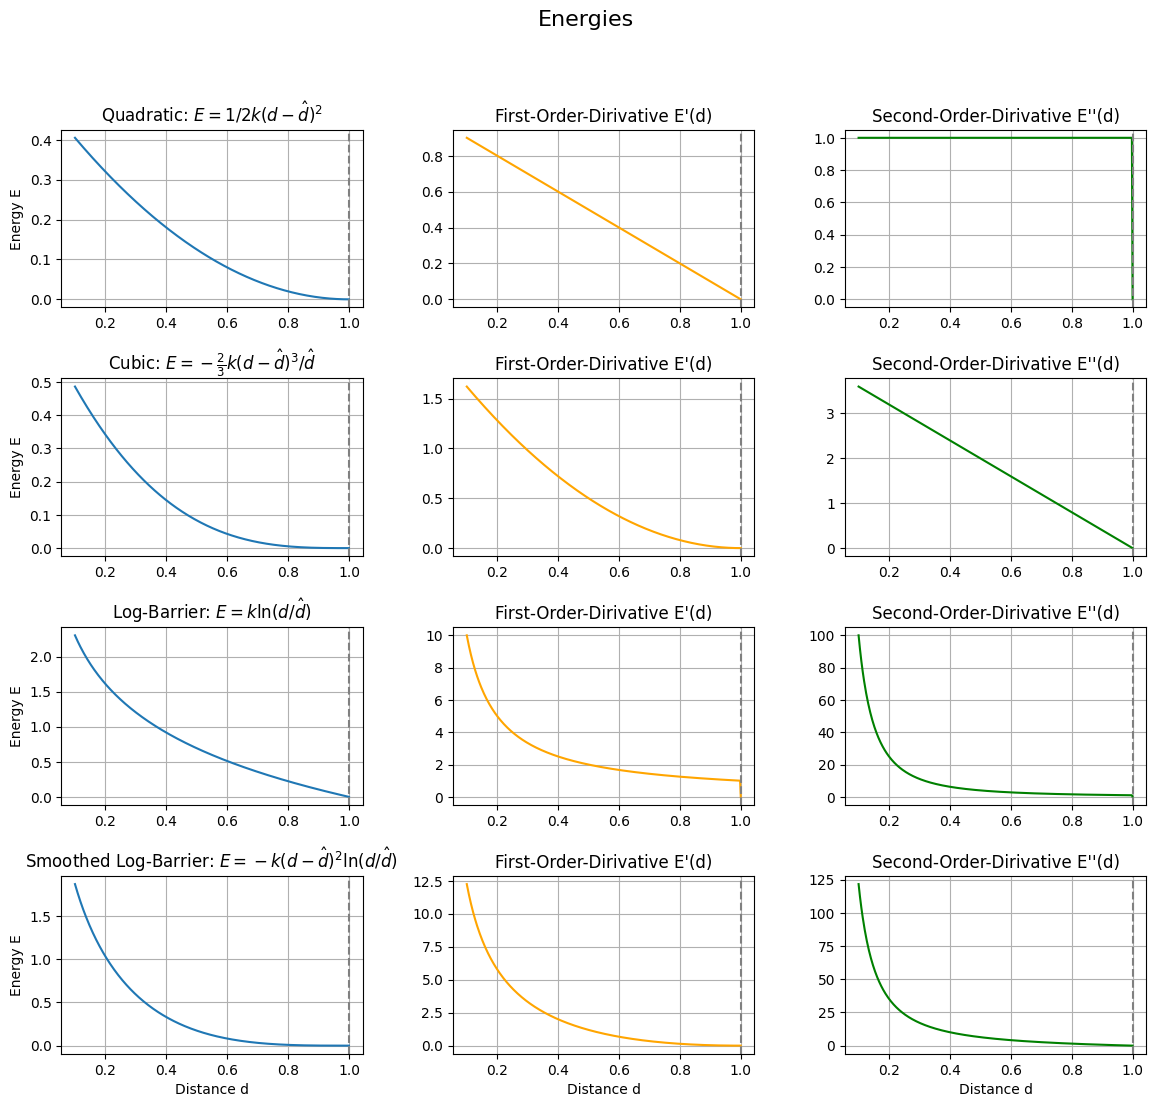

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# ----------------------
# 参数设置
# ----------------------
k = 1.0
d_hat = 1.0
d = jnp.linspace(0.1, 1.0, 400)

# ----------------------
# 定义能量函数
# ----------------------

def E_quadratic(d, k, d_hat):
    return 0.5 * k * (d - d_hat)**2

def E_cubic(d, k, d_hat):
    return -2/3 * k * (d - d_hat)**3 / d_hat

def E_log(d, k, d_hat):
    return -k * jnp.log(d / d_hat)

def E_smooth(d, k, d_hat):
    return -k * (d - d_hat)**2 * jnp.log(d / d_hat)

def truncated(E_func):
    """包装能量函数，使得当 d > d_hat 时 E=0"""
    def E_trunc(d, k, d_hat):
        raw_E = E_func(d, k, d_hat)
        return jnp.where(d < d_hat, raw_E, 0.0)
    return E_trunc
energy_funcs = [
    truncated(E_quadratic),
    truncated(E_cubic),
    truncated(E_log),
    truncated(E_smooth),
]
titles = [
    "Quadratic: $E = 1/2 k (d - \\hat{d})^2$",
    "Cubic: $E = -\\frac{2}{3} k (d - \\hat{d})^3 / \\hat{d}$",
    "Log-Barrier: $E = k \\ln(d / \\hat{d})$",
    "Smoothed Log-Barrier: $E = -k (d - \\hat{d})^2 \\ln(d / \\hat{d})$"
]

# ----------------------
# 自动微分计算
# ----------------------


def compute_energy_and_derivatives(E_func, d_values):
    # 一阶导数
    E_prime = jax.grad(lambda x: E_func(x, k, d_hat))
    # 二阶导数（再对一阶导数求梯度）
    E_double = jax.grad(lambda x: E_prime(x))
    
    E_vals = jax.vmap(lambda x: E_func(x, k, d_hat))(d_values)
    E1_vals = jax.vmap(E_prime)(d_values)
    E2_vals = jax.vmap(E_double)(d_values)
    return E_vals, E1_vals, E2_vals


# ----------------------
# 可视化
# ----------------------
fig, axs = plt.subplots(4, 3, figsize=(14, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, E_func in enumerate(energy_funcs):
    E_vals, E1_vals, E2_vals = compute_energy_and_derivatives(E_func, d)
    
    # E(d)
    axs[i, 0].plot(d, E_vals)
    axs[i, 0].axvline(d_hat, color='gray', linestyle='--')
    axs[i, 0].set_title(titles[i])
    axs[i, 0].set_ylabel("Energy E")
    axs[i, 0].grid(True)
    
    # E'(d)
    axs[i, 1].plot(d, -E1_vals, color='orange')
    axs[i, 1].axvline(d_hat, color='gray', linestyle='--')
    axs[i, 1].set_title("First-Order-Dirivative E'(d)")
    axs[i, 1].grid(True)
    
    # E''(d)
    axs[i, 2].plot(d, E2_vals, color='green')
    axs[i, 2].axvline(d_hat, color='gray', linestyle='--')
    axs[i, 2].set_title("Second-Order-Dirivative E''(d)")
    axs[i, 2].grid(True)

for ax in axs[-1, :]:
    ax.set_xlabel("Distance d")

plt.suptitle("Energies", fontsize=16)
plt.show()


In [3]:
# float dBdD;
# float ddBddD;
# float avg_area  = 1.0f;
# float kappa     = 1.0f;
# float thickness = 0.0f;
# float d_hat     = 0.001f;
# float d         = 0.0005f;


In [4]:
k = 1.0      # kappa
d_hat = 1.0  # reference distance
d_val = 0.5

import jax.numpy as jnp

E_vals, E1_vals, E2_vals = compute_energy_and_derivatives(E_smooth, jnp.array([d_val]))
E = float(E_vals[0])
E1 = float(E1_vals[0])
E2 = float(E2_vals[0])
print(f"d = {d_val}")
print(f"E (Smoothed Log-Barrier) = {E:.12e}")
print(f"E' = {E1:.12e}")
print(f"E'' = {E2:.12e}")

# E = -k*(d-d_hat)**2 * ln(d/d_hat)  => 约 0.17328679513998632
# E' = -k*(2*(d-d_hat)*ln(d/d_hat) + (d-d_hat)**2 / d) => 约 -1.1931471805599453
# E'' = -k*(2*ln(d/d_hat) + 4*(d-d_hat)/d - (d-d_hat)**2 / d**2) => 约 6.386294361119891


d = 0.5
E (Smoothed Log-Barrier) = 1.732867956161e-01
E' = -1.193147182465e+00
E'' = 6.386294364929e+00


In [5]:
# 计算 E_smooth 相对于 s = d*d 的解析导数 (不使用 sqrt)，并验证 2d * dE/ds == dE/dd
def dE_ds_smoothed(d, k, d_hat):
    """返回 dE/ds，其中 s = d*d。
    使用链式法则：dE/ds = (dE/dd) * (1 / (2d))，但我们在此直接写出解析形式以避免对 s 取 sqrt。
    E(d) = -k*(d - d_hat)**2 * ln(d/d_hat)
    dE/dd = -k*(2*(d-d_hat)*ln(d/d_hat) + (d-d_hat)**2 / d)
    因此 dE/ds = dE/dd * 1/(2d) = -k*( (d-d_hat)*ln(d/d_hat)/d + (d-d_hat)**2 / (2*d**2) )
    """
    return -k * ((d - d_hat) * jnp.log(d / d_hat) / d + (d - d_hat)**2 / (2.0 * d**2))

# 数值验证：用 jax.grad 取得相对于 d 的导数，再比较 2d * dE/ds
d_val = 0.5
# 通过 jax.grad 直接对 d 求导（基准）
Eprime_wrt_d = jax.grad(lambda x: E_smooth(x, k, d_hat))(d_val)
# 解析表达式计算 dE/ds（不使用 sqrt）
dE_ds_val = dE_ds_smoothed(d_val, k, d_hat)
# 恢复为 dE/dd 的值：2d * dE/ds
Eprime_from_ds = dE_ds_val * (2.0 * d_val)
print("验证 E_smooth 在 d=", d_val)
print("E' (via jax.grad w.r.t d)   = {0:.12e}".format(float(Eprime_wrt_d)))
print("dE/ds (analytical)           = {0:.12e}".format(float(dE_ds_val)))
print("2d * dE/ds                  = {0:.12e}".format(float(Eprime_from_ds)))
print("difference (grad - 2d*dE/ds) = {0:.3e}".format(float(Eprime_wrt_d - Eprime_from_ds)))

# 还可以对一组 d 值进行矢量验证
d_array = jnp.array([0.2, 0.3, 0.5, 0.8, 0.99])
Eprime_vec = jax.vmap(lambda x: jax.grad(lambda y: E_smooth(y, k, d_hat))(x))(d_array)
dE_ds_vec = jax.vmap(lambda x: dE_ds_smoothed(x, k, d_hat))(d_array)
Eprime_from_ds_vec = dE_ds_vec * (2.0 * d_array)

print("\n矢量化验证:")
for i in range(len(d_array)):
    print(f"d = {d_array[i]:.2f}: E' (grad) = {Eprime_vec[i]:.12e}, 2d*dE/ds = {Eprime_from_ds_vec[i]:.12e}, diff = {Eprime_vec[i] - Eprime_from_ds_vec[i]:.3e}")


验证 E_smooth 在 d= 0.5
E' (via jax.grad w.r.t d)   = -1.193147182465e+00
dE/ds (analytical)           = -1.193147182465e+00
2d * dE/ds                  = -1.193147182465e+00
difference (grad - 2d*dE/ds) = 0.000e+00

矢量化验证:
d = 0.20: E' (grad) = -5.775100708008e+00, 2d*dE/ds = -5.775100708008e+00, diff = 0.000e+00
d = 0.30: E' (grad) = -3.318895101547e+00, 2d*dE/ds = -3.318895101547e+00, diff = 0.000e+00
d = 0.50: E' (grad) = -1.193147182465e+00, 2d*dE/ds = -1.193147182465e+00, diff = 0.000e+00
d = 0.80: E' (grad) = -1.392574012280e-01, 2d*dE/ds = -1.392574012280e-01, diff = 0.000e+00
d = 0.99: E' (grad) = -3.020162694156e-04, 2d*dE/ds = -3.020162694156e-04, diff = 0.000e+00

矢量化验证:
d = 0.20: E' (grad) = -5.775100708008e+00, 2d*dE/ds = -5.775100708008e+00, diff = 0.000e+00
d = 0.30: E' (grad) = -3.318895101547e+00, 2d*dE/ds = -3.318895101547e+00, diff = 0.000e+00
d = 0.50: E' (grad) = -1.193147182465e+00, 2d*dE/ds = -1.193147182465e+00, diff = 0.000e+00
d = 0.80: E' (grad) = -1.3925740122